## 卷积神经网络CNN  识别手写数字

In [102]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = torch.device("mps")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = F.softmax(x, dim=1) ## 这里不要用softmax,因为损失计算的时候使用的CrossEntropyLosCrossEntropyLoCrossEntropyLoss内部已经包含softmax
        return x

    def predict_probs(self, x):
        with torch.no_grad():
            probs = F.softmax(self.forward(x), dim=1)
        return probs

    def predict(self, x):
        with torch.no_grad():
            probs = self.predict_probs(x)
        return torch.argmax(probs, dim=1)

    def get_loss(self, y_pred, y):
        return self.loss_fn(y_pred, y)

    def start_train(self, train_loader, epoch=10):
        loss_history = []
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        device = torch.device("mps")
        for epoch in range(epoch):
            cnt = 0
            loss_sum = 0.0
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                loss_sum += self.train_batch(images, labels, optimizer)
                cnt += 1
            loss_history.append(loss_sum / cnt)
            if epoch % 10 == 0:
                print(f"epoch={epoch}, loss={loss_sum / cnt}")
        return loss_history

    def train_batch(self, images, labels, optimizer):
        self.train()
        optimizer.zero_grad()
        outputs = self.forward(images)
        loss = self.get_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        return loss.item()

In [54]:
cnn = SimpleCNN()
cnn.to(torch.device("mps"))
loss_history = cnn.start_train(train_loader)

epoch=0, loss=0.15694644945218905


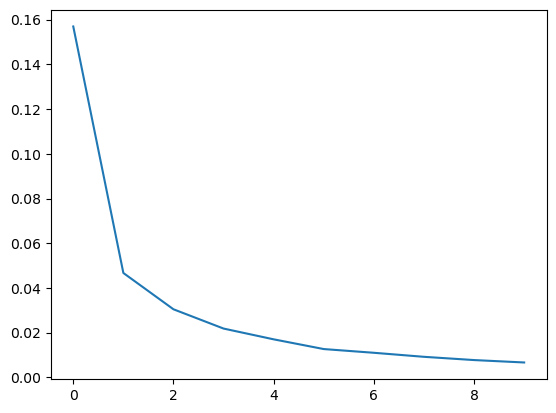

In [55]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(loss_history)
plt.show()

In [73]:
cnn.eval()
y_pred = torch.tensor([], device="mps")
y_true = torch.tensor([], device="mps")
for data, labels in test_loader:
    data = data.to(torch.device("mps"))
    labels = labels.to(torch.device("mps"))
    y_pred_batch = cnn.predict(data)
    y_pred = torch.cat([y_pred, y_pred_batch])
    y_true = torch.cat([y_true, labels])

print(f"acc={(y_pred == y_true).float().sum() / len(y_pred)}")


acc=0.9927999973297119


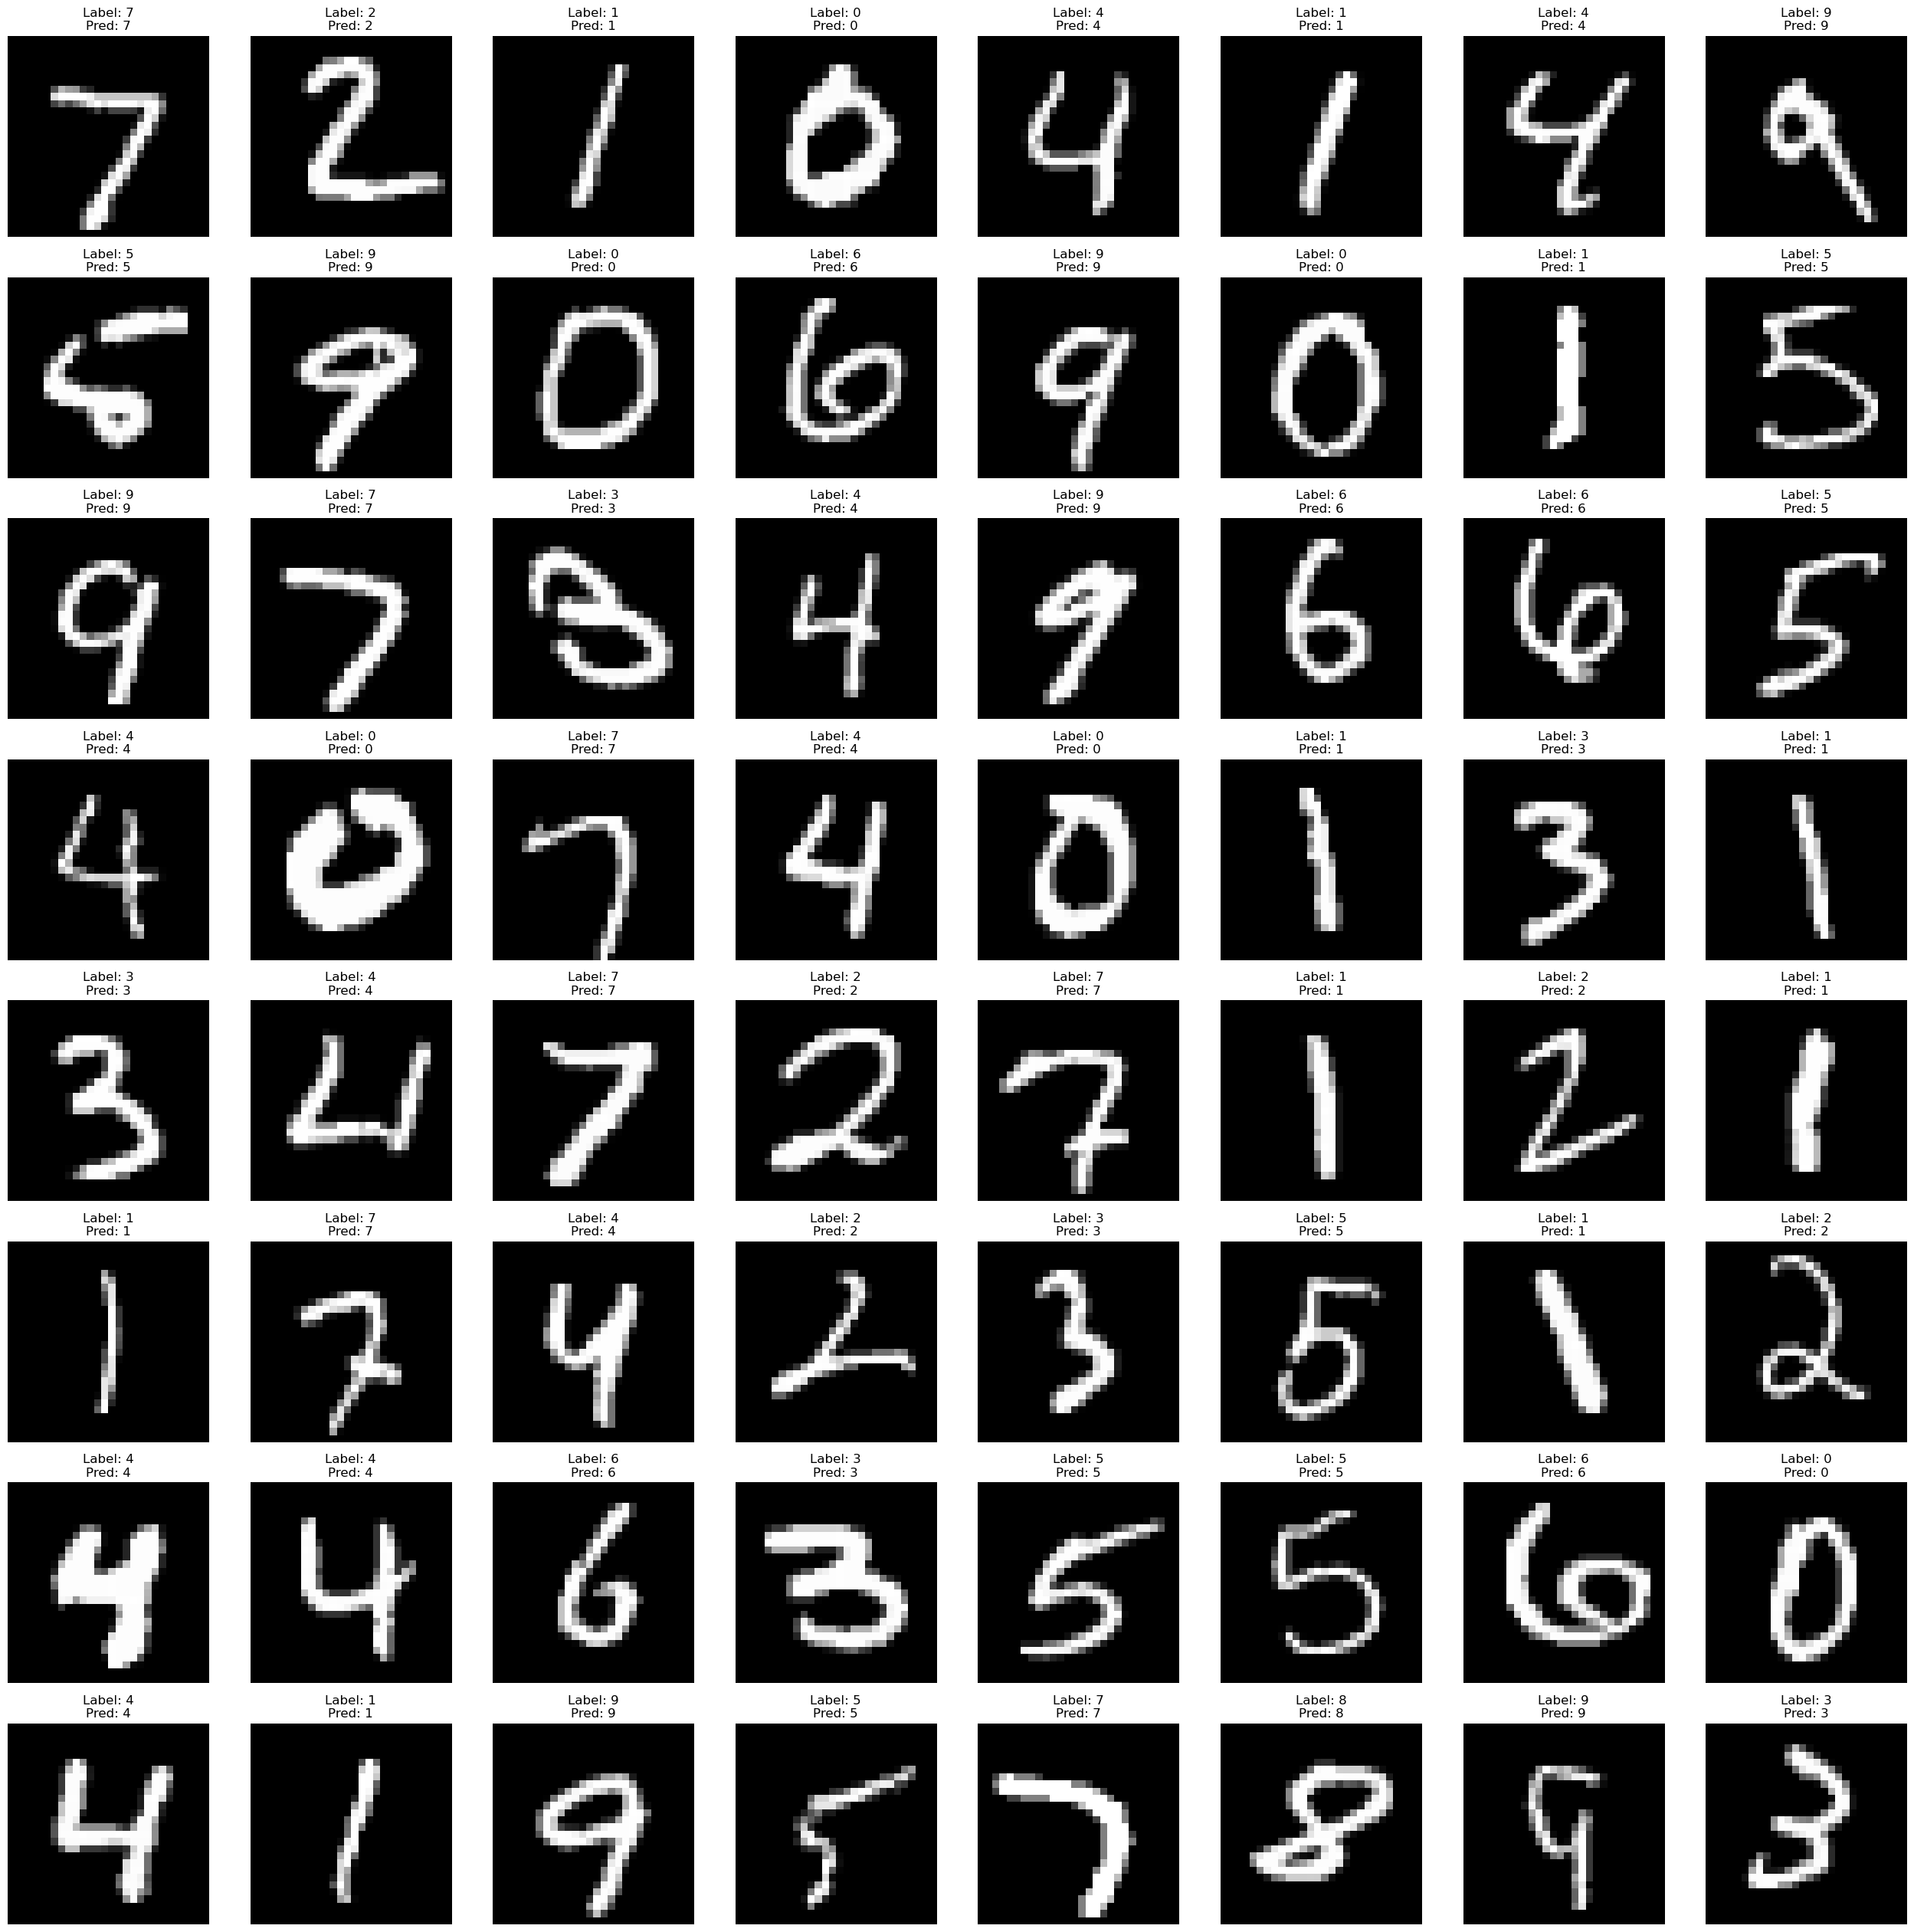

In [101]:
import math
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_mps = images.to(torch.device("mps"))
y_pred = cnn.predict(images_mps)
y_pred = y_pred.cpu().numpy()

rows = 8
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(rows*4, cols*4))
for i in range(rows):
    for j in range(cols):
        pos = i*cols + j
        if labels[pos] == y_pred[pos]:
            axes[i, j].imshow(images[pos][0], cmap='gray')
            pass
        else:
            axes[i, j].imshow(images[pos][0], cmap='viridis')
        axes[i, j].set_title(f"Label: {labels[pos]}\nPred: {y_pred[pos]}")
        axes[i, j].axis('off')
plt.show()